### Import Libraries

In [1]:
import random
import numpy as np
from operator import add
from typing import TypedDict, Literal, Annotated, Literal, List, Optional
from pydantic import BaseModel

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv()

True

### Workflows

#### Sequential Processing

**Sequential workflows** are simple because each node modifies the state one after another.

**1. State Schema**

In [2]:
class State(TypedDict):
    input: int
    output: int

In [3]:
workflow = StateGraph(state_schema=State)

**2. Nodes**

In [4]:
def node_a(state: State)->State:
    input_value = state['input']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE A:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return State(output=output)

def node_b(state: State):
    input_value = state['output']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE B:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": output}

In [5]:
workflow.add_node(node_a)
workflow.add_node(node_b)

**3. Edges**

In [6]:
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

**4. Compile and Run**

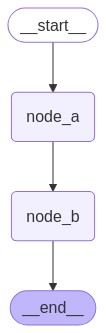

In [7]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [8]:
graph.invoke(
    input = {
        "input": 1,
    },
)

NODE A:
 ->input:1
 ->offset:5
 ->output:6
 
NODE B:
 ->input:6
 ->offset:7
 ->output:13
 


{'input': 1, 'output': 13}

#### Sequential Processing With Configs

- **RunnableConfig** is used to inject external parameters during workflow execution.
- Configs enhance flexibility by making workflows adaptable to different contexts 
without rewriting code.
- They allow external information—such as API results, database fields, or user session data—to influence the workflow's behavior dynamically.

**1. State Schema**

In [9]:
class State(TypedDict):
    input: int
    partial: Annotated[List[int], add]
    results: Annotated[List[int], add]

**2. Nodes**

In [10]:
def node_a(state: State, config: RunnableConfig):
    offset = 0
    if config:
        offset = config.get("configurable", {}).get("offset", 0)
    partial = random.randint(1,10) + offset
    output =  state['input'] + partial
    print(
        f"NODE A:\n "
        f"->input:{output-partial}\n " 
        f"->offset:{offset}\n "
        f"->random:{partial-offset}\n "
        f"->partial:{partial}\n "
        f"->output:{output}\n "
    )
    return {"partial": [partial], "results": [output]}

In [11]:
def node_b(state: State, config: RunnableConfig):
    offset = 0
    if config:
        offset = config.get("configurable", {}).get("offset", 0)
    partial = random.randint(1,10) + offset
    output =  state['results'][-1] + partial
    print(
        f"NODE B:\n "
        f"->input:{output-partial}\n " 
        f"->offset:{offset}\n "
        f"->random:{partial-offset}\n "
        f"->partial:{partial}\n "
        f"->output:{output}\n "
    )
    return {"partial": [partial], "results": [output]}

In [12]:
workflow = StateGraph(State)

workflow.add_node(node_a)
workflow.add_node(node_b)

**3. Edges**

In [13]:
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

**4. Compile and Run**

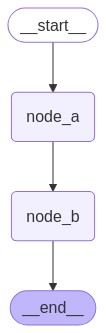

In [14]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [15]:
config = {"configurable": {"offset": 20}}
graph.invoke(
    input = {
        "input": 1,
    }, 
    config = config,
)

NODE A:
 ->input:1
 ->offset:20
 ->random:6
 ->partial:26
 ->output:27
 
NODE B:
 ->input:27
 ->offset:20
 ->random:7
 ->partial:27
 ->output:54
 


{'input': 1, 'partial': [26, 27], 'results': [27, 54]}

#### Parallel Processing with Reducer

**Parallel workflows** require reducers to avoid update conflicts.

**Without reducer**

Changing the workflow so `start` sends the state to both `node_a` and `node_b` in parallel causes a problem:

- Both nodes try to update the `output` field at the same time.
- Results in an **InvalidUpdateError** because the output field was designed to store only a single integer.

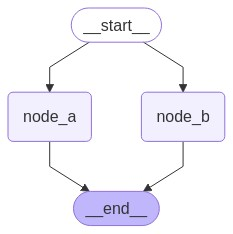

In [16]:
class State(TypedDict):
    input: int
    output: int

def node_a(state: State):
    input_value = state['input']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE A:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": output}

def node_b(state: State):
    input_value = state['input'] # Coming from input
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE B:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": output}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge(START, "node_b")
workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)
graph = workflow.compile()
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [17]:
try:
    graph.invoke(
        input = {
            "input": 1,
        }, 
    )
except Exception as e:
    print(e)

NODE A:
 ->input:1
 ->offset:1
 ->output:2
 NODE B:
 ->input:1
 ->offset:7
 ->output:8
 

At key 'output': Can receive only one value per step. Use an Annotated key to handle multiple values.


**With Reducer**

Reducers resolve conflicts by defining how to combine multiple updates to the same field.

In [18]:
add([1,2,3],[4,5,6])

[1, 2, 3, 4, 5, 6]

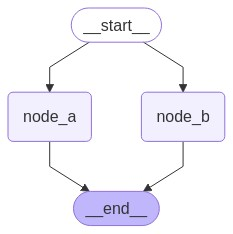

In [19]:
class State(TypedDict):
    input: int
    output: Annotated[List[int], add]

def node_a(state: State):
    input_value = state['input']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE A:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": [output]} # now it's a List of ints

def node_b(state: State):
    input_value = state['input'] # Coming from input
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE B:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": [output]} # now it's a List of ints


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge(START, "node_b")
workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [20]:
graph.invoke(
    input = {
        "input": 1,
    }, 
)

NODE B:
 ->input:1
 ->offset:7
 ->output:8
 NODE A:
 ->input:1
 ->offset:5
 ->output:6
 



{'input': 1, 'output': [6, 8]}

#### Conditional Router

**1. State Schema**

In [21]:
class State(TypedDict):
    input: str
    action: Literal["reverse", "upper"]
    output: str

In [22]:
workflow = StateGraph(State)

**2. Nodes**

In [23]:
def node_a(state: State):
    print("Node A\n")
    output =  state['input'][::-1]
    print(f"output: {output}")
    return {"output": output}

def node_b(state: State):
    print("Node B\n")
    output = state['input'].upper()
    print(f"output: {output}")
    return {"output": output}

workflow.add_node(node_a)
workflow.add_node(node_b)


**3. Routing Function**

In [24]:
def routing_function(state: State):
    action = state["action"]
    if action == "reverse":
        return "node_a"
    if action == "upper":
        return "node_b"

**4. Edges**

Use conditional edges to control the flow of data:

- START → routing_function to decide the path.
- node_a → END for reverse.
- node_b → END for uppercase.

In add_conditional_edges() method, use source, path and path_map as the necessary arguments for routing.

In [25]:
workflow.add_conditional_edges(
    source=START, 
    path=routing_function, 
    path_map=["node_a", "node_b"]
)

workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)

**5. Compile and Run**

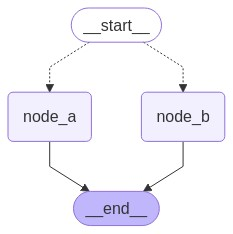

In [26]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [27]:
graph.invoke(
    input = {
        "input": "Some input",
        "action": "upper",
    }, 
)

Node B

output: SOME INPUT


{'input': 'Some input', 'action': 'upper', 'output': 'SOME INPUT'}

In [28]:
graph.invoke(
    input = {
        "input": "Some input",
        "action": "reverse",
    }, 
)

Node A

output: tupni emoS


{'input': 'Some input', 'action': 'reverse', 'output': 'tupni emoS'}

### Call LLMs

#### Call LLMs with State

In [29]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [30]:
class State(TypedDict):
    question: str
    response: str

In [31]:
def model(state: State):
    question = state["question"]
    response = llm.invoke([
        SystemMessage("You're a data science specialist"),
        HumanMessage(question)
    ])

    return {"response": response.content}

In [32]:
workflow = StateGraph(State)

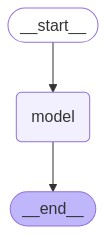

In [33]:
workflow.add_node("model", model)

workflow.add_edge(START, "model")
workflow.add_edge("model", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [34]:
result = graph.invoke(
    input={
        "question": "What is the Large language models?"
    }, 
)

In [35]:
result

{'question': 'What is the Large language models?',
 'response': 'Large language models (LLMs) are a type of artificial intelligence (AI) that are designed to understand, generate, and manipulate human language. They are built using deep learning techniques, particularly neural networks, and are trained on vast amounts of text data to learn the statistical patterns and structures of language. Here are some key characteristics and components of LLMs:\n\n1. **Architecture**: Most LLMs are based on transformer architecture, which allows them to process and generate text efficiently. Transformers use mechanisms like self-attention to weigh the importance of different words in a sentence, enabling them to capture context and relationships between words effectively.\n\n2. **Training**: LLMs are trained on diverse datasets that include books, articles, websites, and other text sources. This training helps them learn grammar, facts, reasoning abilities, and even some level of common sense knowl

#### Call LLMs with Custom State and Langgraph operator

- In workflows involving messages, a simple `operator.add` doesn’t work well when merging structured messages.
- Instead, LangGraph provides the `add_messages` reducer.

In [36]:
add_messages(
    left = [
        SystemMessage("You're a helpful assistant"),
        HumanMessage("Hi!")
    ],
    right = AIMessage("Hello! How can I assist you today?")
)

[SystemMessage(content="You're a helpful assistant", id='1c3127d5-81dd-4d0a-93d9-00154d823a88'),
 HumanMessage(content='Hi!', id='126e32f0-111b-4d6c-b8aa-50c0b5d19bf2'),
 AIMessage(content='Hello! How can I assist you today?', id='5ad0554f-fd88-4ae2-bb2d-c08bff8f50ef')]

In [37]:
class State(TypedDict):
    messages:Annotated[List[AnyMessage], add_messages]

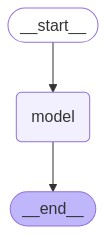

In [38]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

def model(state: State):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": response}

workflow = StateGraph(State)

workflow.add_node("model", model)

workflow.add_edge(START, "model")
workflow.add_edge("model", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [39]:
result = graph.invoke(
    input={
        "messages": [HumanMessage("What is the Large language models?")]}, 
)

for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is the Large language models?
================================== Ai Message ==================================

Large language models (LLMs) are a type of artificial intelligence (AI) designed to understand, generate, and manipulate human language. They are built using deep learning techniques, particularly neural networks, and are trained on vast amounts of text data from diverse sources, such as books, articles, websites, and more. Here are some key characteristics and features of LLMs:

1. **Scale**: LLMs are characterized by their large number of parameters, often in the billions or even trillions. This scale allows them to capture complex patterns and nuances in language.

2. **Training**: They are typically trained using unsupervised or semi-supervised learning methods, where the model learns to predict the next word in a sentence given the previous words. This process helps the model understan

#### Call LLMs with Langgraph MessagesState

- MessageState simplifies using LangChain messages in workflows without needing custom schemas.｜

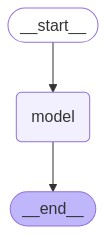

In [40]:
def model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": response}

workflow = StateGraph(MessagesState)

workflow.add_node("model", model)

workflow.add_edge(START, "model")
workflow.add_edge("model", END)

graph = workflow.compile()
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [41]:
result = graph.invoke(
    input={
        "messages": [HumanMessage("What is the Large language models?")]}, 
)

for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is the Large language models?
================================== Ai Message ==================================

Large language models (LLMs) are a type of artificial intelligence (AI) designed to understand, generate, and manipulate human language. They are built using deep learning techniques, particularly neural networks, and are trained on vast amounts of text data from diverse sources, such as books, articles, websites, and more. Here are some key characteristics and features of LLMs:

1. **Scale**: LLMs are characterized by their large number of parameters, often in the billions or even trillions. This scale allows them to capture complex patterns and nuances in language.

2. **Training**: They are typically trained using unsupervised or semi-supervised learning methods, where the model learns to predict the next word in a sentence given the previous words. This process helps the model understan

#### Call LLMs with Langgraph MessagesState and Config

In [42]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

MessageState automatically includes a messages list with a reducer.

In [43]:
class State(MessagesState):
    question:str

Checks if a user's name is present in the config.
If so, injects a SystemMessage to personalize the greeting.

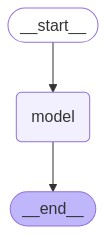

In [44]:
def model(state: State, config: RunnableConfig):
    question = state["question"]
    messages = state["messages"]
    name = None
    if config:
        name = config["configurable"].get("name")

    if name and not messages:
        messages.append(
            SystemMessage(
                "Help the following user. \n"
                f"Name={name} \n"
                "Give an initial greeting before responding."
            )
        )

    messages.append(HumanMessage(question))
    response = llm.invoke(messages)
    messages.append(response)

    return {"messages": messages}

workflow = StateGraph(State)

workflow.add_node("model", model)

workflow.add_edge(START, "model")
workflow.add_edge("model", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

RunnableConfig is used to inject external parameters during workflow execution.

In [45]:
result = graph.invoke(
    input={"question": "What is the meaning of life?"},
    config={"configurable": {"name": "Tim"}}
)

for message in result['messages']:
    message.pretty_print()

================================ System Message ================================

Help the following user. 
Name=Tim 
Give an initial greeting before responding.
================================ Human Message =================================

What is the meaning of life?
================================== Ai Message ==================================

Hello, Tim! The meaning of life is a profound question that has been explored by philosophers, theologians, and thinkers throughout history. Different cultures and individuals may have varying interpretations. Some find meaning through relationships, love, and connection with others, while others seek purpose through personal achievements, spirituality, or contributing to the greater good. Ultimately, it may be a personal journey for each individual to discover what gives their life meaning. What are your thoughts on it?


### States

#### Pydantic

In [46]:
class State(BaseModel):
    input_data: List[float]  # Raw numerical data
    normalized_data: Optional[List[float]] = None  # Normalized data

def normalize_node(state: State):
    """
    Simple min-max normalization node that scales data to [0,1] range
    """
    data = state.input_data
    min_val = min(data)
    max_val = max(data)
    
    # Min-max normalization
    normalized = [(x - min_val) / (max_val - min_val) for x in data]
    
    print(f"Input data: {data}")
    print(f"Normalized data: {[round(x, 3) for x in normalized]}")
    
    return {"normalized_data": normalized}

# Create the workflow
workflow = StateGraph(State)

# Add the normalization node
workflow.add_node("normalize", normalize_node)

# Define the flow
workflow.add_edge(START, "normalize")
workflow.add_edge("normalize", END)

# Compile the graph
graph = workflow.compile()

# Example usage
result = graph.invoke(
    {
        "input_data": [1, 5, 2, 8, 3]
    }
)

Input data: [1.0, 5.0, 2.0, 8.0, 3.0]
Normalized data: [0.0, 0.571, 0.143, 1.0, 0.286]


#### State Machines

In [47]:
class State(BaseModel):
    stage: Optional[Literal["📊 Data", "🎯 Training", "📈 Validation", "✅ Complete"]] = None
    continue_training: bool
    messages: Annotated[List[str], add] = []
    epoch: Annotated[int, add] = 0
    current_loss: float = float('inf')

def prepare_data(state: State):
    stage = "📊 Data"
    message = f"{stage}: Preparing training and validation splits..."
    messages = [message]
    # Simulate data preparation
    return {
        "stage": stage, 
        "messages": messages, 
        "epoch": 1
    }

def train_model(state: State):
    stage = "🎯 Training"
    epoch = state.epoch
    # Simulate training loss
    current_loss = 1.0 / (epoch + np.random.random())
    
    message = f"{stage}: Epoch {epoch} - Training Loss: {current_loss:.4f}"
    messages = [message]
    
    return {
        "stage": stage, 
        "messages": messages,
        "current_loss": current_loss,
        "epoch": epoch + 1  # Increment epoch counter
    }

def validate_model(state: State):
    stage = "📈 Validation"
    current_loss = state.current_loss
    continue_training = state.continue_training
    
    messages = []
    
    if not continue_training:
        message = f"{stage}: Validation Loss: {current_loss:.4f}"
        messages.append(message)
    else:
        if state.epoch >= 10:
            messages.append("🔚 Maximum epochs (10) reached")
            messages.append("Setting continue_training to False")
            continue_training = False
    
    messages.append("----------------------------------------------------")
    
    return {
        "stage": stage, 
        "messages": messages,
        "continue_training": continue_training,
        "current_loss": current_loss
    }

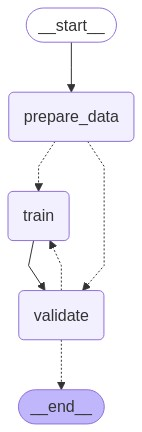

In [48]:
# Create the workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("prepare_data", prepare_data)
workflow.add_node("train", train_model)
workflow.add_node("validate", validate_model)

# Add basic flow from START to prepare_data
workflow.add_edge(START, "prepare_data")

# Add conditional check after data preparation
def should_start_training(state: State):
    if not state.continue_training:
        return "validate"
    return "train"

workflow.add_conditional_edges(
    source="prepare_data",
    path=should_start_training,
    path_map=["train", "validate"]
)

# Add edges from train to validate
workflow.add_edge("train", "validate")

# Add conditional check after validation
def should_continue_training(state: State):
    if not state.continue_training:  # Check the continue_training flag
        return END
    return "train"

workflow.add_conditional_edges(
    source="validate",
    path=should_continue_training,
    path_map=["train", END]
)

# Compile the graph
graph = workflow.compile()

# Display the workflow graph
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [49]:
# Example usage with different initial conditions
print("🤖 ------------ ML TRAINING CONTROLLER ------------🤖")
print("\nCase 1: Normal Training Run")
result = graph.invoke({"continue_training": True})
for message in result['messages']:
    print(message)

print("\nCase 2: Training Disabled")
result = graph.invoke({"continue_training": False})
for message in result['messages']:
    print(message)

🤖 ------------ ML TRAINING CONTROLLER ------------🤖

Case 1: Normal Training Run
📊 Data: Preparing training and validation splits...
🎯 Training: Epoch 1 - Training Loss: 0.5795
----------------------------------------------------
🎯 Training: Epoch 3 - Training Loss: 0.2915
----------------------------------------------------
🎯 Training: Epoch 7 - Training Loss: 0.1339
🔚 Maximum epochs (10) reached
Setting continue_training to False
----------------------------------------------------

Case 2: Training Disabled
📊 Data: Preparing training and validation splits...
📈 Validation: Validation Loss: inf
----------------------------------------------------
